In [ ]:
import torch
from torch import nn, Tensor
import torch.nn.functional as functional
from torchvision.datasets import CIFAR100
import pandas as pd
from torchvision import transforms
from torchvision.transforms import v2, AutoAugment, AutoAugmentPolicy
from torch.backends import cudnn
from torch import GradScaler
from torch import optim
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from timm import create_model
import os

In [ ]:

os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
cudnn.benchmark = True


class CachedDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.data = [(image, label) for image, label in dataset]
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image, label = self.data[index]
        if self.transform:
            image = self.transform(image)
        return image, label


class CIFAR100N(Dataset):
    def __init__(self, root, transform=None, noisy_labels=None):
        self.cifar100 = CIFAR100(root=root, train=True, download=True, transform=transform)
        self.noisy_labels = noisy_labels

    def __len__(self):
        return len(self.cifar100)

    def __getitem__(self, idx):
        image, _ = self.cifar100[idx]
        label = self.noisy_labels[idx]
        return image, label

In [ ]:
def create_plots():
    epochs_range = list(range(1, EPOC + 1))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_accuracies, label="Train Accuracy", marker='o')
    plt.plot(epochs_range, val_accuracies, label="Validation Accuracy", marker='x')
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_losses, label="Train Loss", marker='o')
    plt.plot(epochs_range, val_losses, label="Validation Loss", marker='x')
    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

<ipython-input-4-875dd6207352>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  noise_data = torch.load(noise_file_path)


Files already downloaded and verified
Files already downloaded and verified
Index 0: Clean Label: 19, Noisy Label: 19
Index 1: Clean Label: 29, Noisy Label: 63
Index 2: Clean Label: 0, Noisy Label: 10
Index 3: Clean Label: 11, Noisy Label: 11
Index 4: Clean Label: 1, Noisy Label: 1


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

{'url': 'https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth', 'hf_hub_id': 'timm/efficientnet_b0.ra_in1k', 'architecture': 'efficientnet_b0', 'tag': 'ra_in1k', 'custom_load': False, 'input_size': (3, 224, 224), 'fixed_input_size': False, 'interpolation': 'bicubic', 'crop_pct': 0.875, 'crop_mode': 'center', 'mean': (0.485, 0.456, 0.406), 'std': (0.229, 0.224, 0.225), 'num_classes': 1000, 'pool_size': (7, 7), 'first_conv': 'conv_stem', 'classifier': 'classifier'}
Starting training...


Epoch 1: 100%|██████████| 196/196 [04:08<00:00,  1.27s/it, Batch Loss=3.4505, Epoch Loss=3.3108, Accuracy=32.38%]


Epoch 1/10 - Train Acc: 32.38%, Val Acc: 62.25%, Best Val Acc: 62.25%



Epoch 2: 100%|██████████| 196/196 [04:01<00:00,  1.23s/it, Batch Loss=3.4138, Epoch Loss=2.8862, Accuracy=44.19%]


Epoch 2/10 - Train Acc: 44.19%, Val Acc: 66.05%, Best Val Acc: 66.05%



Epoch 3: 100%|██████████| 196/196 [04:01<00:00,  1.23s/it, Batch Loss=3.4594, Epoch Loss=2.7873, Accuracy=46.58%]


Epoch 3/10 - Train Acc: 46.58%, Val Acc: 67.82%, Best Val Acc: 67.82%



Epoch 4: 100%|██████████| 196/196 [04:01<00:00,  1.23s/it, Batch Loss=3.2357, Epoch Loss=2.6714, Accuracy=48.39%]


Epoch 4/10 - Train Acc: 48.39%, Val Acc: 68.77%, Best Val Acc: 68.77%



Epoch 5: 100%|██████████| 196/196 [03:59<00:00,  1.22s/it, Batch Loss=2.0971, Epoch Loss=2.5056, Accuracy=53.03%]


Epoch 5/10 - Train Acc: 53.03%, Val Acc: 69.25%, Best Val Acc: 69.25%



Epoch 6: 100%|██████████| 196/196 [04:01<00:00,  1.23s/it, Batch Loss=2.8811, Epoch Loss=2.4906, Accuracy=53.94%]


Epoch 6/10 - Train Acc: 53.94%, Val Acc: 70.00%, Best Val Acc: 70.00%



Epoch 7: 100%|██████████| 196/196 [04:01<00:00,  1.23s/it, Batch Loss=2.8911, Epoch Loss=2.3988, Accuracy=55.26%]


Epoch 7/10 - Train Acc: 55.26%, Val Acc: 70.10%, Best Val Acc: 70.10%



Epoch 8: 100%|██████████| 196/196 [04:01<00:00,  1.23s/it, Batch Loss=2.5049, Epoch Loss=2.3224, Accuracy=58.33%]


Epoch 8/10 - Train Acc: 58.33%, Val Acc: 70.49%, Best Val Acc: 70.49%



Epoch 9: 100%|██████████| 196/196 [04:01<00:00,  1.23s/it, Batch Loss=2.7436, Epoch Loss=2.1990, Accuracy=61.31%]


Epoch 9/10 - Train Acc: 61.31%, Val Acc: 71.00%, Best Val Acc: 71.00%



Epoch 10: 100%|██████████| 196/196 [04:01<00:00,  1.23s/it, Batch Loss=1.6007, Epoch Loss=2.1212, Accuracy=62.84%]


Epoch 10/10 - Train Acc: 62.84%, Val Acc: 70.56%, Best Val Acc: 71.00%



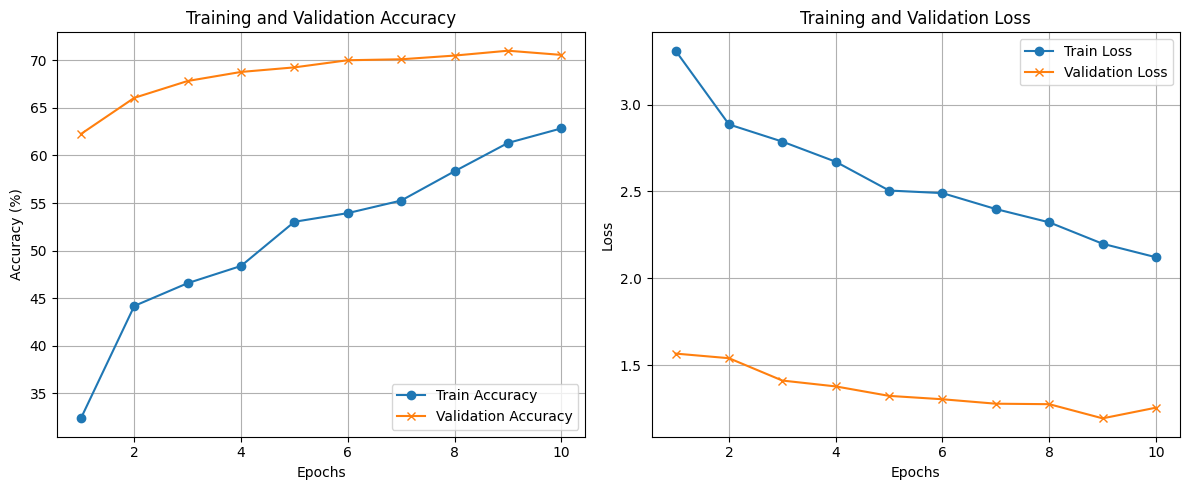

In [ ]:
if __name__ == '__main__':
    noise_file_path = './drive/MyDrive/data/CIFAR-100_human.pt'
    noise_data = torch.load(noise_file_path)
    noisy_labels = noise_data['noisy_label']

    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomCrop(224, padding=4),
        # transforms.RandomCrop(40, padding=4),
        # transforms.RandomHorizontalFlip(),
        # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        # transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
    ])

    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
    ])

    train_set = CIFAR100N(
        root='./drive/MyDrive/data',
        transform=train_transform,
        noisy_labels=noisy_labels
    )

    test_set = CIFAR100(
        root='./drive/MyDrive/data',
        train=False,
        download=True,
        transform=test_transform
    )

    # print("Caching training dataset...")
    # train_set = CachedDataset(train_set)
    # print("Caching completed!")
    #
    # print("Caching testing dataset...")
    # test_set = CachedDataset(test_set)
    # print("Caching completed!")

    # print("Verifying noisy labels in training set...")
    # for i in range(5):
    #     image, noisy_label = train_set[i]
    #     clean_label = train_set.cifar100.targets[i]
    #     print(f"Index {i}: Clean Label: {clean_label}, Noisy Label: {noisy_label}")

    # for i in range(5):
    #     image, label = train_set[i]
    #     print(f"Image shape after transform: {image.shape}, Label: {label}")

    assert len(train_set) == 50000, "Dataset length mismatch!"

    for i in range(5):
        clean_label = train_set.cifar100.targets[i]  # Clean label
        noisy_label = train_set.noisy_labels[i]  # Noisy label
        print(f"Index {i}: Clean Label: {clean_label}, Noisy Label: {noisy_label}")
        # assert clean_label != noisy_label, f"Clean and noisy labels are identical at index {i}!"

    train_loader = DataLoader(train_set, batch_size=256, shuffle=True)

    # print("\nVerifying noisy labels in DataLoader batches...")
    # for batch_idx, (inputs, noisy_labels) in enumerate(train_loader):
    #     clean_labels = torch.tensor([train_set.cifar100.targets[idx] for idx in range(len(noisy_labels))])
    #     print(f"Batch {batch_idx} - First 5 Clean Labels: {clean_labels[:5]}")
    #     print(f"Batch {batch_idx} - First 5 Noisy Labels: {noisy_labels[:5]}")
    #     break

    test_loader = DataLoader(test_set, batch_size=256)

    EPOC = 10
    import torch
    import torch.nn as nn

    # model = create_model("resnet18", pretrained=True, num_classes=100)
    model = create_model("efficientnet_b0", pretrained=True, num_classes=100)
    # model = create_model("resnet34", pretrained=True, num_classes=100)

    print(model.pretrained_cfg)

    # model = model.to('cuda')


    class SymmetricCrossEntropy(nn.Module):
        def __init__(self, alpha=0.1, beta=1.0):
            super().__init__()
            self.alpha = alpha
            self.beta = beta
            self.ce = nn.CrossEntropyLoss()

        def forward(self, preds, targets):
            ce_loss = self.ce(preds, targets)
            preds_softmax = torch.softmax(preds, dim=1)
            rce_loss = -torch.mean(torch.sum(preds_softmax * torch.log(preds_softmax + 1e-12), dim=1))
            return self.alpha * ce_loss + self.beta * rce_loss


    # criterion = SymmetricCrossEntropy(alpha=0.1, beta=1.0)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.0001)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOC)

    train_accuracies = []
    val_accuracies = []
    train_losses = []
    val_losses = []

    cutMix = v2.CutMix(num_classes=100, alpha=1.0)
    mixUp = v2.MixUp(num_classes=100, alpha=1.0)

    rand_choice = v2.RandomChoice([cutMix, mixUp])

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)


    # scaler = GradScaler(enabled=torch.cuda.is_available())
    # enable_half
    # = torch.cuda.is_available()

    def train_one_epoch(epoch):
        model.train()
        correct, total, total_loss = 0, 0, 0.0

        batch_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}")

        for inputs, targets in batch_bar:
            inputs, targets = inputs.to(device), targets.to(device)
            inputs, targets = rand_choice(inputs, targets)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            total_loss += loss.item() * inputs.size(0)
            predicted = outputs.argmax(1)
            total += targets.size(0)
            correct += predicted.eq(targets.argmax(1)).sum().item()

            avg_loss = total_loss / total
            accuracy = 100.0 * correct / total
            batch_bar.set_postfix({
                "Batch Loss": f"{loss.item():.4f}",
                "Epoch Loss": f"{avg_loss:.4f}",
                "Accuracy": f"{accuracy:.2f}%"
            })

        avg_loss = total_loss / total
        accuracy = 100.0 * correct / total
        return accuracy, avg_loss


    @torch.no_grad()
    def evaluate():
        model.eval()
        correct = 0
        total = 0
        total_loss = 0.0

        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            total_loss += loss.item() * inputs.size(0)
            predicted = outputs.argmax(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        avg_loss = total_loss / total
        accuracy = 100.0 * correct / total
        return accuracy, avg_loss


    # Training Loop
    best_model_state = model.state_dict()
    best_val_accuracy = 0.0

    print("Starting training...")
    for epoch in range(EPOC):
        train_acc, train_loss = train_one_epoch(epoch)
        val_acc, val_loss = evaluate()

        train_accuracies.append(train_acc)
        train_losses.append(train_loss)
        val_accuracies.append(val_acc)
        val_losses.append(val_loss)

        scheduler.step()

        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            best_model_state = model.state_dict()

        print(
            f"Epoch {epoch + 1}/{EPOC} - Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, Best Val Acc: {best_val_accuracy:.2f}%")
        print()

    torch.save(best_model_state, "best_model_2.pth")

    create_plots()